In [77]:
import pandas as pd
from datetime import datetime

# -------------------------------
# Load Datasets
# -------------------------------
bfi = pd.read_csv("BFI_Nepal.csv")
hh = pd.read_csv("NPHC_2021_Households_by_Ownership.csv")
census = pd.read_csv("census.csv")

# -------------------------------
# 2Clean Household (Ward-level) Dataset
# -------------------------------
# Drop any non-data rows (header repeats, if present)
hh = hh.drop(0, errors='ignore')

# Rename columns
hh.columns = ['local_level', 'ward_code', 'total_hh', 'owned', 'rented', 'institutional', 'other']

# Convert numeric columns
for col in ['ward_code', 'total_hh', 'owned', 'rented', 'institutional', 'other']:
    hh[col] = pd.to_numeric(hh[col], errors='coerce')

# Lowercase & strip local_level for merging
hh['local_level'] = hh['local_level'].str.lower().str.strip()

# -------------------------------
# 3. Aggregate Households to Municipality
# -------------------------------
hh_muni = hh.groupby('local_level', as_index=False).agg({
    'total_hh': 'sum'
})

# -------------------------------
# 4. Clean Census Dataset (Local-level Population)
# -------------------------------
# Rename for consistency
census = census.rename(columns={'Local Level Name':'local_level',
                                'Total population':'population'})
# Lowercase & strip
census['local_level'] = census['local_level'].str.lower().str.strip()

# -------------------------------
# 5. Merge HH + Census Population
# -------------------------------
muni_features = hh_muni.merge(
    census[['local_level','population']],
    on='local_level',
    how='left'
)

# -------------------------------
# 6. Clean BFI Dataset
# -------------------------------
# Extract municipality from address
def extract_municipality(address):
    if pd.isnull(address):
        return None
    return str(address).split(',')[-1].lower().strip().replace('metropolitian','metropolitan')

bfi['municipality'] = bfi['address'].apply(extract_municipality)

# -------------------------------
# 7. Merge BFI + Municipality Features
# -------------------------------
bfi_merged = bfi.merge(
    muni_features,
    left_on='municipality',
    right_on='local_level',
    how='left'
)

# -------------------------------
# 8. Feature Engineering
# -------------------------------
# Extract open_year
bfi_merged['open_year'] = pd.to_datetime(bfi_merged['open_date'], errors='coerce').dt.year

# Branch age
current_year = datetime.now().year
bfi_merged['branch_age'] = current_year - bfi_merged['open_year']

# Branch density (number of branches per 1000 population in municipality)
branch_count = bfi_merged.groupby('municipality')['branch_name'].count().reset_index()
branch_count = branch_count.rename(columns={'branch_name':'num_branches'})
bfi_merged = bfi_merged.merge(branch_count, on='municipality', how='left')
bfi_merged['branch_density'] = bfi_merged['num_branches'] / bfi_merged['population'] * 1000

# -------------------------------
# 9. Save ML-ready CSV
# -------------------------------
bfi_merged.to_csv('BFI_ML.csv', index=False)

print("ML-ready BFI dataset saved as BFI_ML.csv")
print("Shape:", bfi_merged.shape)
print("Columns:", bfi_merged.columns.tolist())
print("\nSample head:\n", bfi_merged.head())


ML-ready BFI dataset saved as BFI_ML.csv
Shape: (12356, 15)
Columns: ['type', 'name', 'code', 'address', 'district', 'branch_name', 'open_date', 'municipality', 'local_level', 'total_hh', 'population', 'open_year', 'branch_age', 'num_branches', 'branch_density']

Sample head:
                         type  \
0  Commercial Bank (Class A)   
1  Commercial Bank (Class A)   
2  Commercial Bank (Class A)   
3  Commercial Bank (Class A)   
4  Commercial Bank (Class A)   

                                                name      code  \
0  \n                                            ...  11003001   
1  \n                                            ...  11003002   
2  \n                                            ...  11003003   
3  \n                                            ...  11003004   
4  \n                                            ...  11003005   

                            address   district               branch_name  \
0  20, Kathmandu Metropolitian City  Kathmandu          

In [78]:
# -------------------------------
# Cell 1: Imports and Load Data
# -------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the merged dataset
BFI_ML = pd.read_csv("BFI_ML.csv")  # This is your final merged dataset

# Check basic info
print("=== BFI_ML Dataset ===")
print(BFI_ML.shape)
print(BFI_ML.columns)
print(BFI_ML.head())
print(BFI_ML.isnull().sum())


=== BFI_ML Dataset ===
(12356, 15)
Index(['type', 'name', 'code', 'address', 'district', 'branch_name',
       'open_date', 'municipality', 'local_level', 'total_hh', 'population',
       'open_year', 'branch_age', 'num_branches', 'branch_density'],
      dtype='object')
                        type  \
0  Commercial Bank (Class A)   
1  Commercial Bank (Class A)   
2  Commercial Bank (Class A)   
3  Commercial Bank (Class A)   
4  Commercial Bank (Class A)   

                                                name      code  \
0  \n                                            ...  11003001   
1  \n                                            ...  11003002   
2  \n                                            ...  11003003   
3  \n                                            ...  11003004   
4  \n                                            ...  11003005   

                            address   district               branch_name  \
0  20, Kathmandu Metropolitian City  Kathmandu           New R

In [79]:
# -------------------------------
# Cell 2: Numerical Summaries
# -------------------------------

# Describe numeric columns
num_summary = BFI_ML.describe()
print("=== Numeric Summary ===")
print(num_summary)

# Count of categorical features
cat_columns = BFI_ML.select_dtypes(include='object').columns
for col in cat_columns:
    print(f"\nUnique values for {col}: {BFI_ML[col].nunique()}")
    print(BFI_ML[col].value_counts().head(10))


=== Numeric Summary ===
               code      total_hh     population     open_year    branch_age  \
count  1.235600e+04   7562.000000    7562.000000  12356.000000  12356.000000   
mean   1.254424e+07  15018.490479   58094.900423   2015.724749      9.275251   
std    1.600250e+06   9958.424060   34194.645391      9.013497      9.013497   
min    1.100100e+07    320.000000    1272.000000   1951.000000      2.000000   
25%    1.101701e+07   7922.000000   30503.000000   2015.000000      5.000000   
50%    1.206003e+07  12961.000000   52911.000000   2018.000000      7.000000   
75%    1.403011e+07  18135.000000   77281.000000   2020.000000     10.000000   
max    3.400100e+07  45295.000000  154886.000000   2023.000000     74.000000   

       num_branches  branch_density  
count  12356.000000     7562.000000  
mean     118.492230        0.696468  
std      228.533313        0.686307  
min        1.000000        0.023095  
25%       17.000000        0.357480  
50%       36.000000        

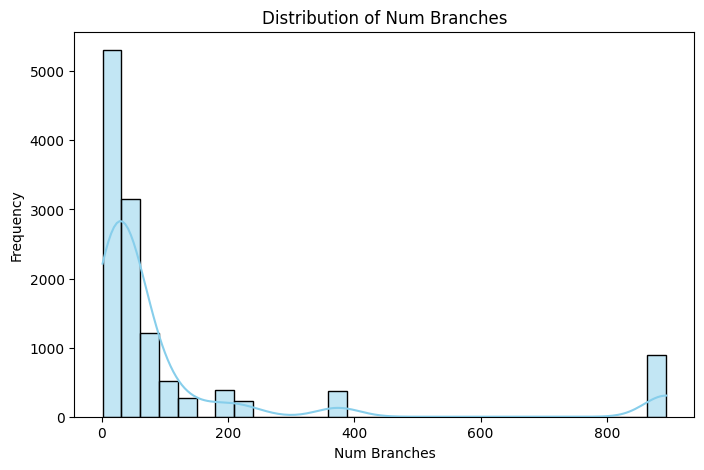

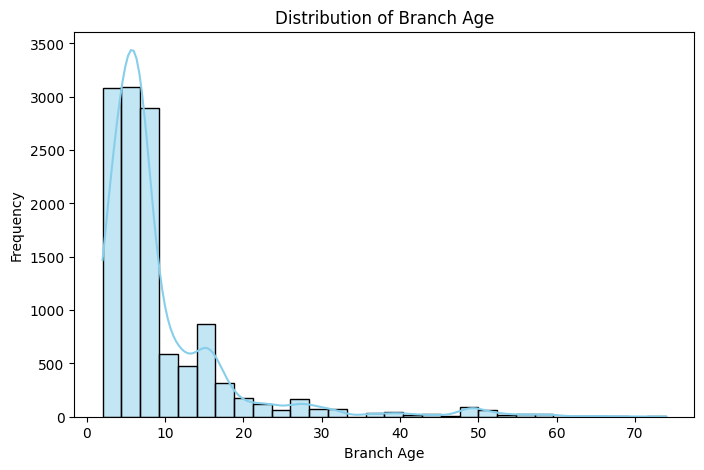

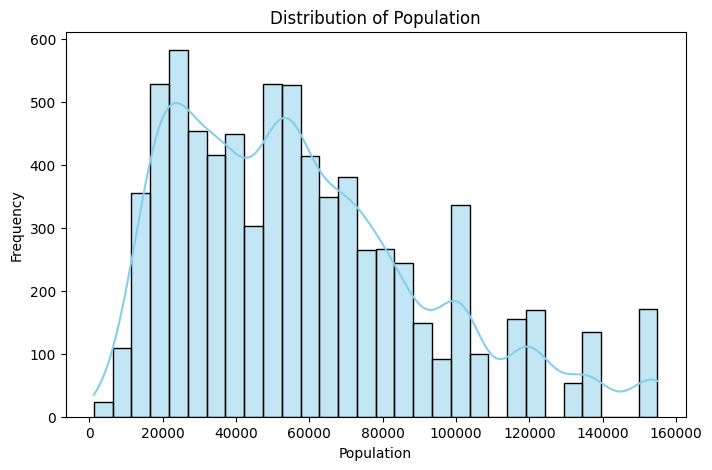

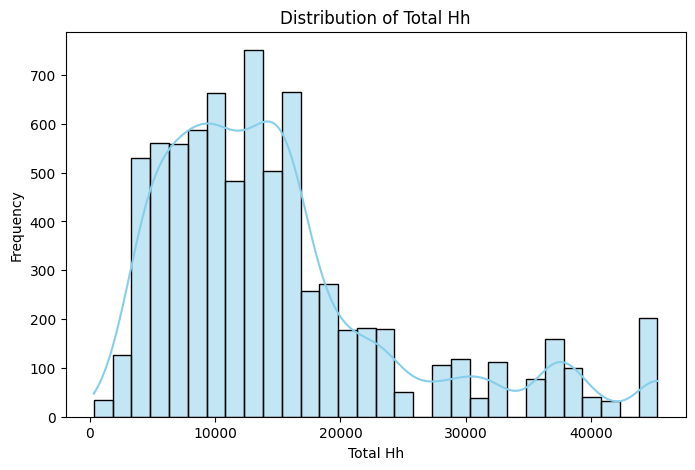

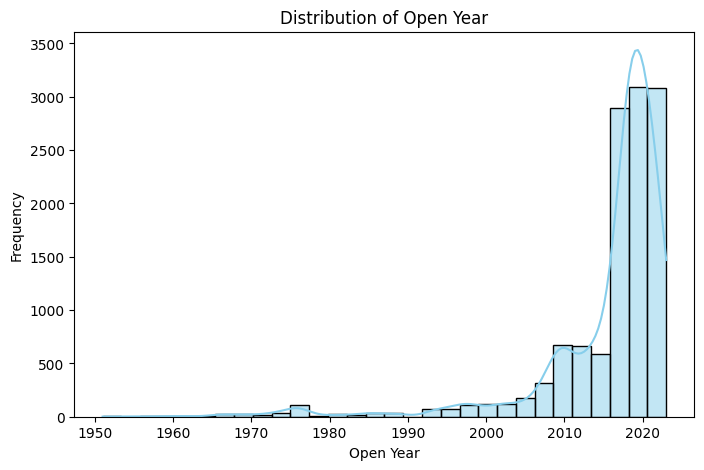

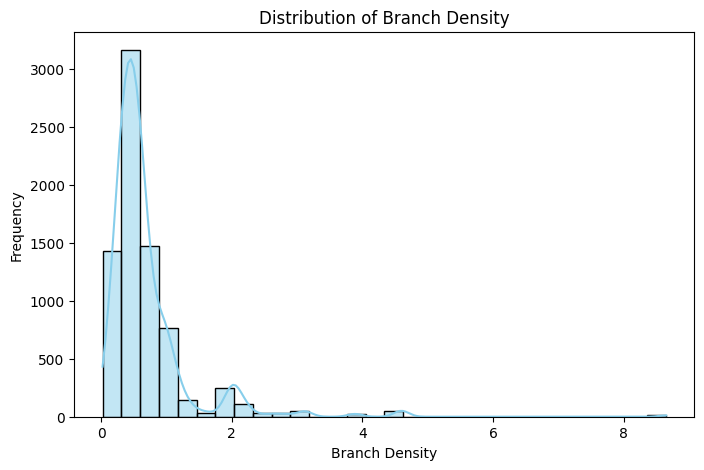

In [80]:
# -------------------------------
# Cell 3: Numeric Feature Distributions
# -------------------------------
import matplotlib.pyplot as plt
import seaborn as sns

numeric_cols = ['num_branches', 'branch_age', 'population', 'total_hh', 'open_year', 'branch_density']

for col in numeric_cols:
    plt.figure(figsize=(8,5))
    sns.histplot(BFI_ML[col], bins=30, kde=True, color='skyblue')
    plt.title(f"Distribution of {col.replace('_',' ').title()}")
    plt.xlabel(col.replace('_',' ').title())
    plt.ylabel("Frequency")
    plt.savefig(f"dist_{col}.png")  # Save figure with clear name
    plt.show()


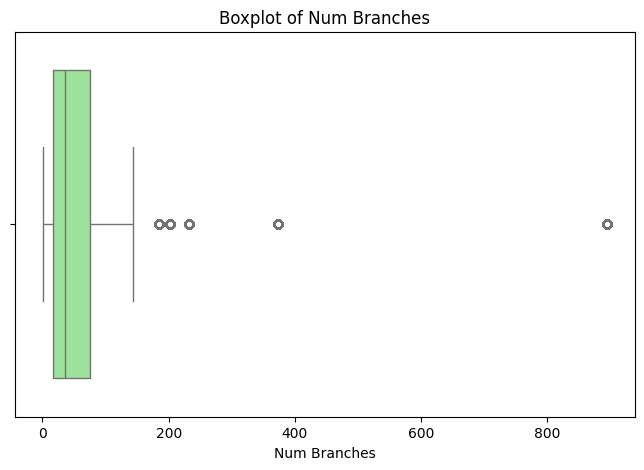

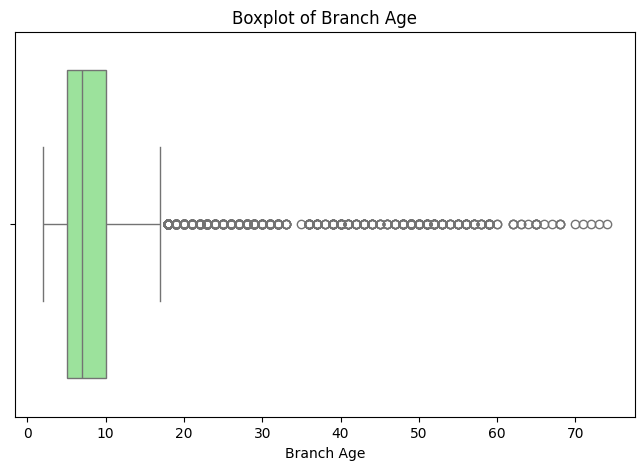

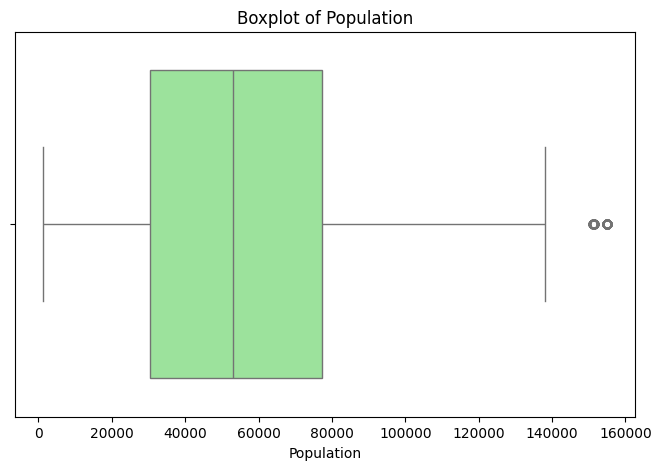

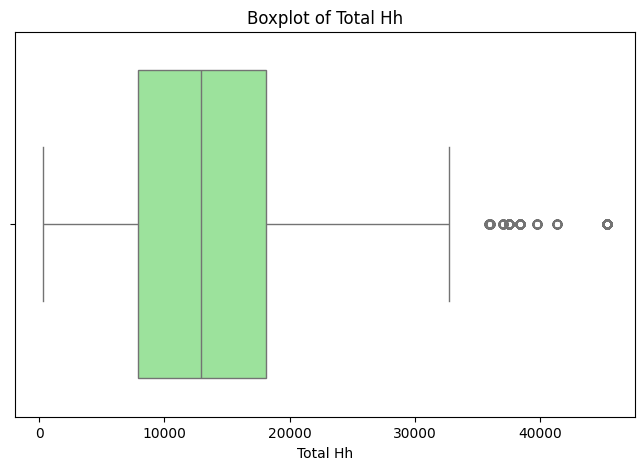

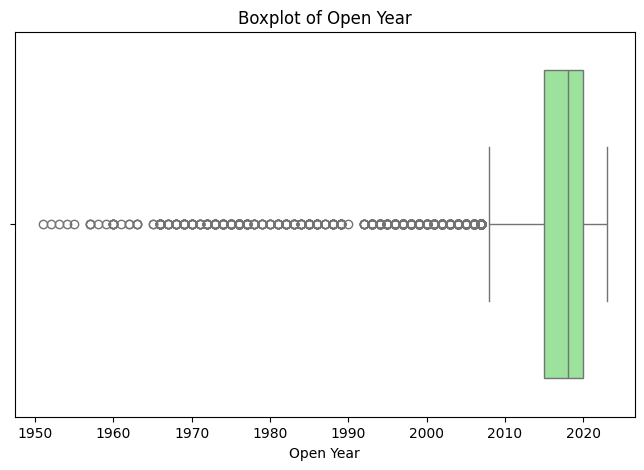

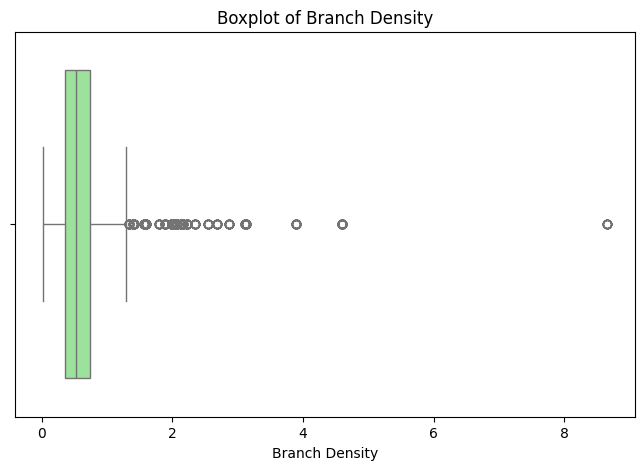

In [81]:
# -------------------------------
# Cell 4: Boxplots for Numeric Features
# -------------------------------
for col in numeric_cols:
    plt.figure(figsize=(8,5))
    sns.boxplot(x=BFI_ML[col], color='lightgreen')
    plt.title(f"Boxplot of {col.replace('_',' ').title()}")
    plt.xlabel(col.replace('_',' ').title())
    plt.savefig(f"box_{col}.png")
    plt.show()


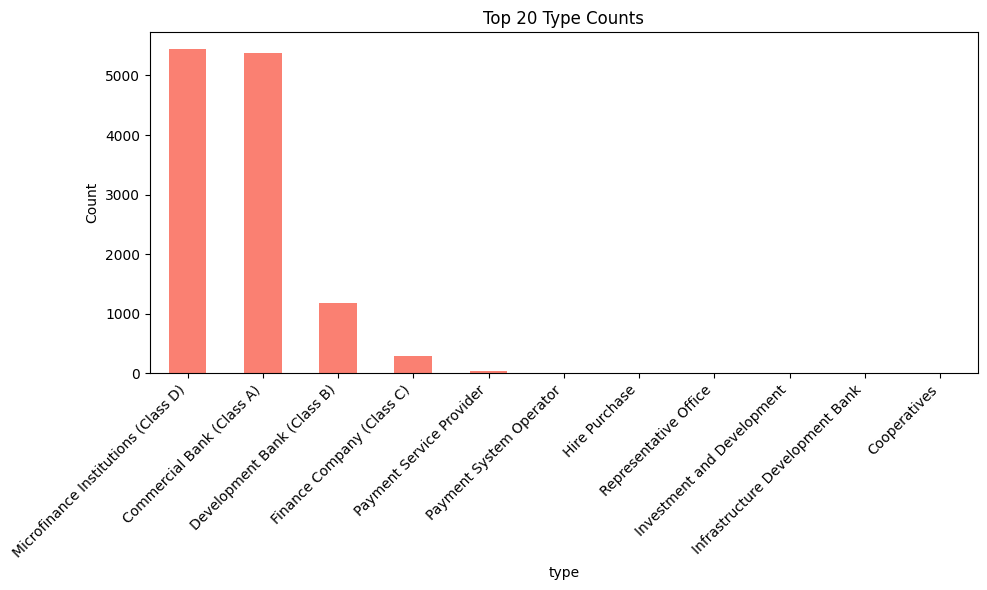

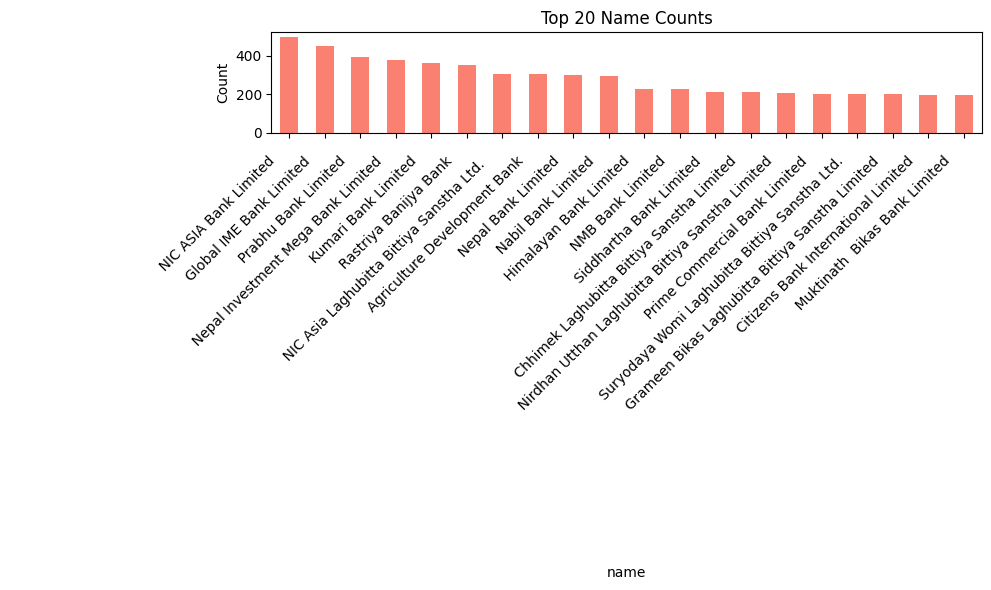

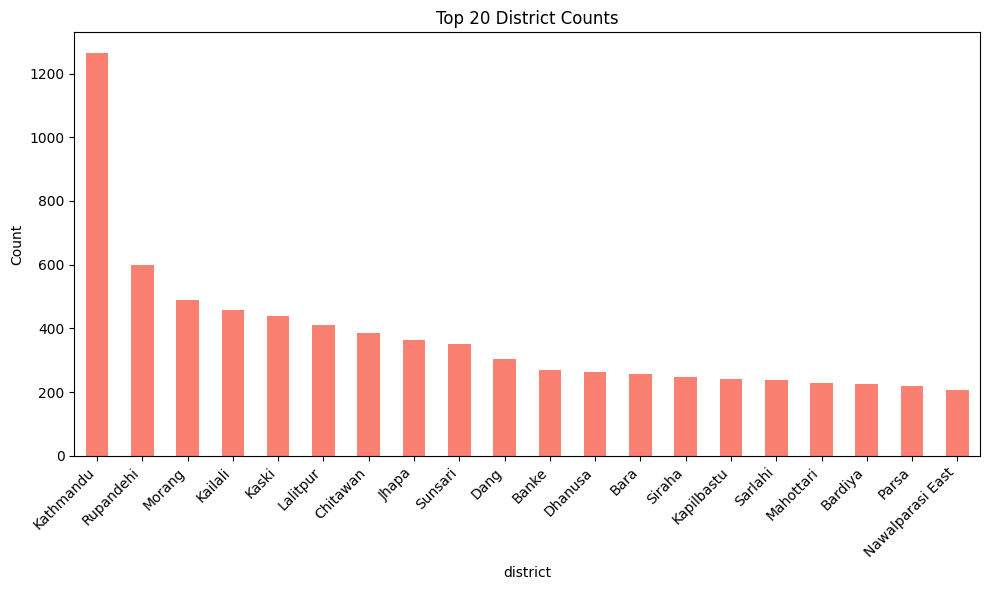

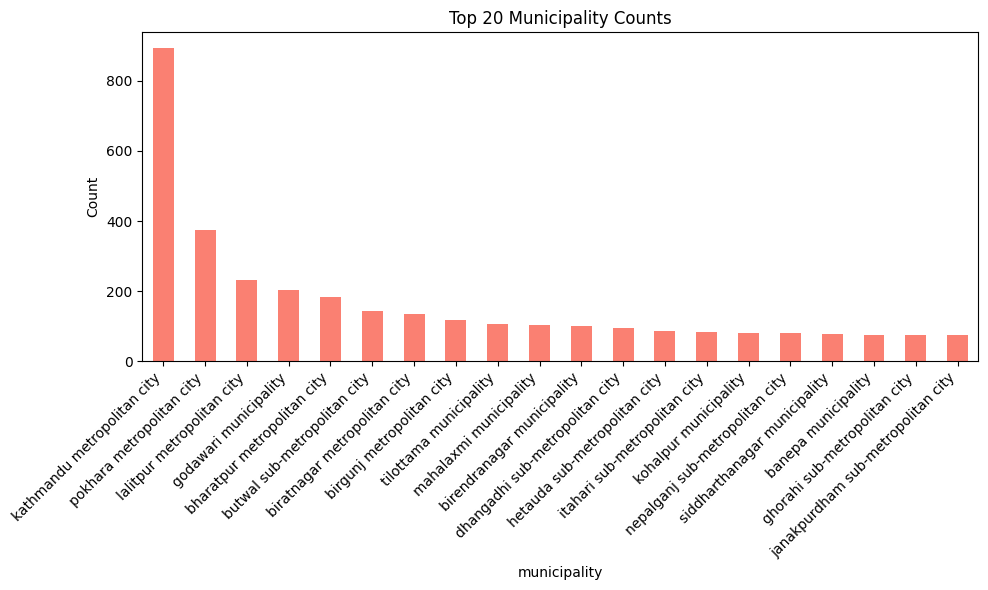

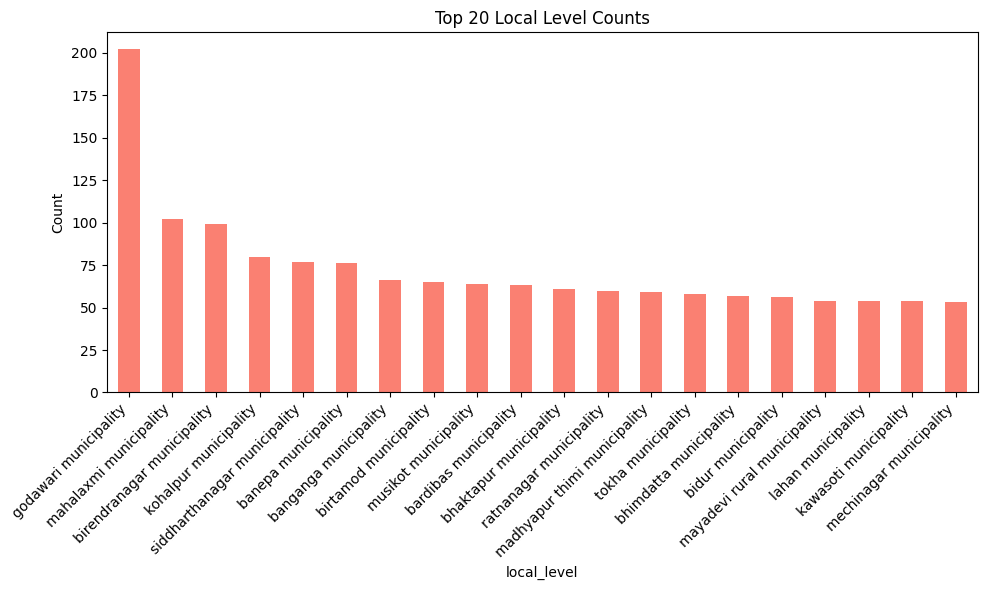

In [82]:
# -------------------------------
# Cell 5: Categorical Feature Counts
# -------------------------------
categorical_cols = ['type', 'name', 'district', 'municipality', 'local_level']

for col in categorical_cols:
    plt.figure(figsize=(10,6))
    BFI_ML[col].value_counts().head(20).plot(kind='bar', color='salmon')
    plt.title(f"Top 20 {col.replace('_',' ').title()} Counts")
    plt.ylabel("Count")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig(f"top20_{col}.png")
    plt.show()


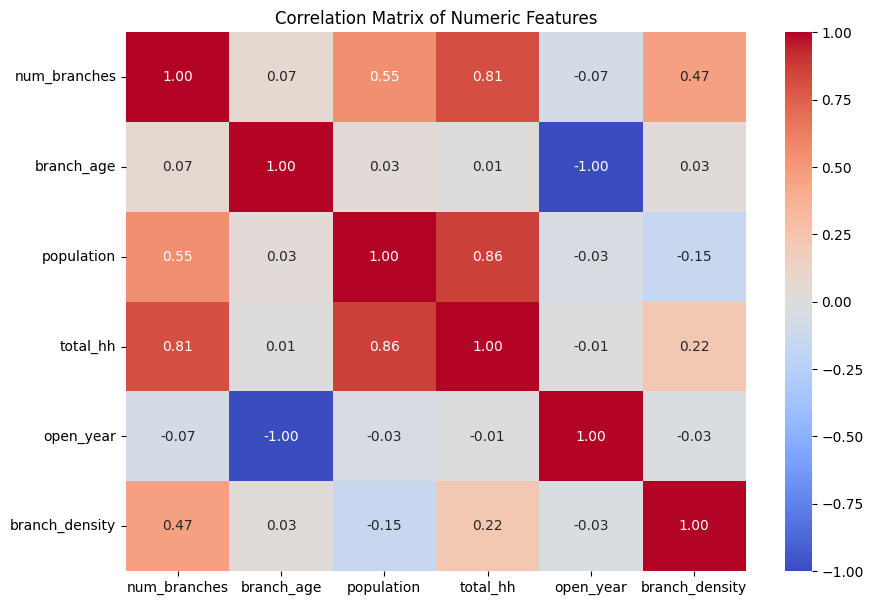

In [83]:
# -------------------------------
# Cell 6: Correlation Heatmap
# -------------------------------
plt.figure(figsize=(10,7))
corr = BFI_ML[numeric_cols].corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Matrix of Numeric Features")
plt.savefig("correlation_matrix.png")
plt.show()


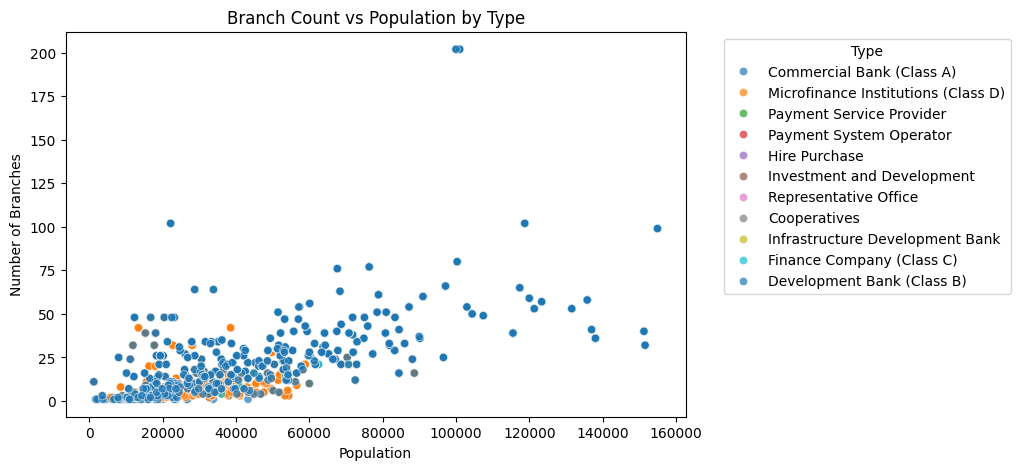

In [84]:
# -------------------------------
# Cell 7: Branch Count vs Population
# -------------------------------
plt.figure(figsize=(8,5))
sns.scatterplot(x='population', y='num_branches', data=BFI_ML, hue='type', palette='tab10', alpha=0.7)
plt.title("Branch Count vs Population by Type")
plt.xlabel("Population")
plt.ylabel("Number of Branches")
plt.legend(title='Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.savefig("branch_vs_population.png", bbox_inches='tight')
plt.show()


In [85]:
# -----------------------------
# Documentation-Support EDA: Local-Level Summary
# Purpose: Numeric summaries, outlier detection, and key figures for documentation only
# -----------------------------

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Create folder to save figures
os.makedirs("figures_doc", exist_ok=True)
os.makedirs("tables_doc", exist_ok=True)

# -----------------------------
# Load processed local-level dataset
# (This should already have numeric features computed)
# -----------------------------
data = pd.read_csv("BFI_ML.csv")  # replace with your processed local-level dataset

# -----------------------------
# 1. Numeric Summary
# -----------------------------
numeric_cols = ['num_branches', 'branch_age', 'population', 'total_hh', 'branch_density', 'open_year']
summary = data[numeric_cols].describe().transpose()
summary.to_csv("tables_doc/numeric_summary.csv")
print("=== Numeric Summary ===")
print(summary)

# -----------------------------
# 2. Outlier Detection using IQR
# -----------------------------
outliers = {}
for col in numeric_cols:
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5*IQR
    upper = Q3 + 1.5*IQR
    outliers[col] = data[(data[col] < lower) | (data[col] > upper)][col]
    print(f"\nOutliers for {col} (IQR method):")
    print(outliers[col].sort_values(ascending=False).head(10))  # show top 10

# -----------------------------
# 3. Key Figures
# -----------------------------
# Histogram: population
plt.figure(figsize=(8,5))
sns.histplot(data['population'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of Local-Level Population')
plt.xlabel('Population')
plt.ylabel('Frequency')
plt.tight_layout()
plt.savefig("figures_doc/population_hist.png")
plt.close()

# Histogram: branch_age
plt.figure(figsize=(8,5))
sns.histplot(data['branch_age'], bins=30, kde=True, color='orange')
plt.title('Distribution of Branch Age')
plt.xlabel('Branch Age (years)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.savefig("figures_doc/branch_age_hist.png")
plt.close()

# Histogram: total households
plt.figure(figsize=(8,5))
sns.histplot(data['total_hh'], bins=30, kde=True, color='green')
plt.title('Distribution of Total Households')
plt.xlabel('Total Households')
plt.ylabel('Frequency')
plt.tight_layout()
plt.savefig("figures_doc/total_hh_hist.png")
plt.close()

# Bar plot: top 10 branch types
type_counts = data['type'].value_counts().head(10)
plt.figure(figsize=(8,5))
sns.barplot(x=type_counts.values, y=type_counts.index, palette='magma')
plt.title('Top 10 Branch Types by Count')
plt.xlabel('Number of Branches')
plt.ylabel('Branch Type')
plt.tight_layout()
plt.savefig("figures_doc/type_top10.png")
plt.close()
type_counts.to_csv("tables_doc/type_top10.csv")

# Bar plot: top 10 municipalities by branch count
mun_counts = data['municipality'].value_counts().head(10)
plt.figure(figsize=(8,5))
sns.barplot(x=mun_counts.values, y=mun_counts.index, palette='viridis')
plt.title('Top 10 Municipalities by Branch Count')
plt.xlabel('Number of Branches')
plt.ylabel('Municipality')
plt.tight_layout()
plt.savefig("figures_doc/municipality_top10.png")
plt.close()
mun_counts.to_csv("tables_doc/municipality_top10.csv")

# Scatter plot: num_branches vs population
plt.figure(figsize=(8,5))
sns.scatterplot(x='population', y='num_branches', data=data)
plt.title('Number of Branches vs Population')
plt.xlabel('Population')
plt.ylabel('Number of Branches')
plt.tight_layout()
plt.savefig("figures_doc/branches_vs_population.png")
plt.close()

# Correlation matrix
corr = data[numeric_cols].corr()
corr.to_csv("tables_doc/correlation_matrix.csv")
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Correlation Matrix of Numeric Features')
plt.tight_layout()
plt.savefig("figures_doc/correlation_matrix.png")
plt.close()

print("\nAll figures saved in 'figures_doc/' and numeric tables in 'tables_doc/'")


=== Numeric Summary ===
                  count          mean           std          min          25%  \
num_branches    12356.0    118.492230    228.533313     1.000000     17.00000   
branch_age      12356.0      9.275251      9.013497     2.000000      5.00000   
population       7562.0  58094.900423  34194.645391  1272.000000  30503.00000   
total_hh         7562.0  15018.490479   9958.424060   320.000000   7922.00000   
branch_density   7562.0      0.696468      0.686307     0.023095      0.35748   
open_year       12356.0   2015.724749      9.013497  1951.000000   2015.00000   

                         50%           75%            max  
num_branches       36.000000     76.000000     894.000000  
branch_age          7.000000     10.000000      74.000000  
population      52911.000000  77281.000000  154886.000000  
total_hh        12961.000000  18135.000000   45295.000000  
branch_density      0.522928      0.747728       8.647799  
open_year        2018.000000   2020.000000    20

/tmp/ipython-input-4179277626.py:81: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=type_counts.values, y=type_counts.index, palette='magma')
/tmp/ipython-input-4179277626.py:93: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=mun_counts.values, y=mun_counts.index, palette='viridis')



All figures saved in 'figures_doc/' and numeric tables in 'tables_doc/'


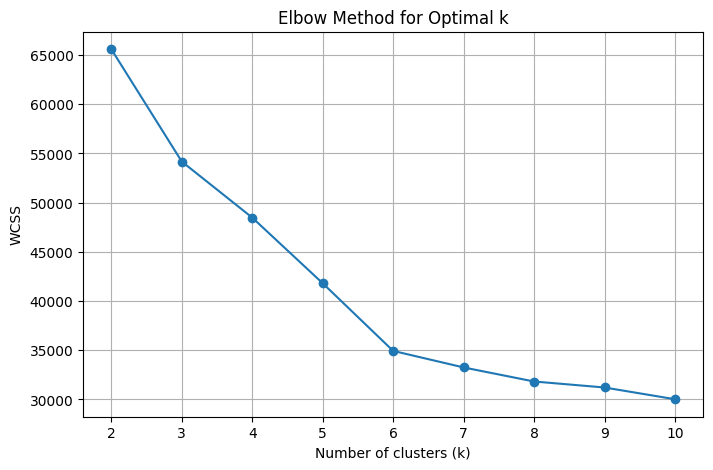

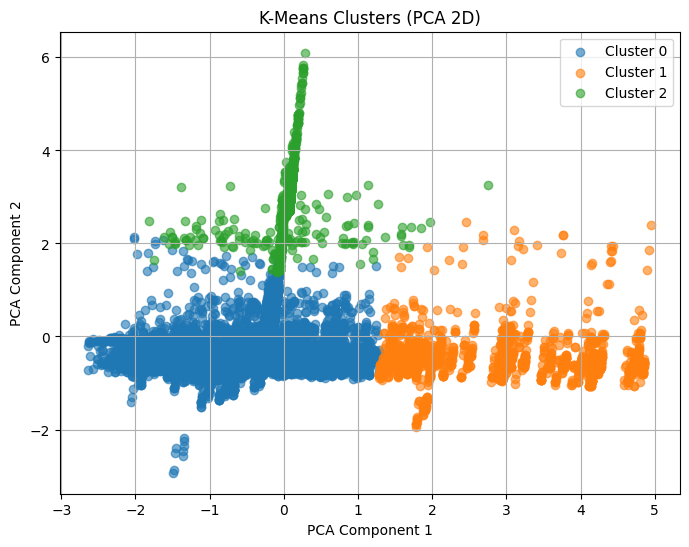

=== Cluster Summary (Mean of Numeric Features) ===
                num_branches  branch_age  population  total_hh  branch_density
kmeans_cluster                                                                
0                      52.78        8.09    48124.43  11671.90            0.60
1                      79.43        8.71   110379.58  31814.91            0.86
2                     704.43       19.63    52836.15  12915.61            0.55


In [86]:
# -------------------------------
# Cell: K-Means Clustering (Full)
# -------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# ===============================
# 1. Define Features
# ===============================
# Numeric features for clustering
numeric_features = ['num_branches', 'branch_age', 'population', 'total_hh', 'branch_density']

# Categorical features (one-hot encode later)
categorical_features = ['type', 'municipality']  # adjust if needed

# ===============================
# 2. Handle Missing Values
# ===============================
# Fill numeric NaNs with median
BFI_ML[numeric_features] = BFI_ML[numeric_features].fillna(BFI_ML[numeric_features].median())

# Fill categorical NaNs with mode
BFI_ML[categorical_features] = BFI_ML[categorical_features].fillna(BFI_ML[categorical_features].mode().iloc[0])

# ===============================
# 3. Feature Scaling & Encoding
# ===============================
# Standardize numeric features
scaler = StandardScaler()
X_num_scaled = scaler.fit_transform(BFI_ML[numeric_features])

# One-hot encode categorical features
X_cat = pd.get_dummies(BFI_ML[categorical_features])

# Combine numeric and categorical
X = np.hstack([X_num_scaled, X_cat.values])

# ===============================
# 4. Elbow Method for Optimal k
# ===============================
wcss = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(8,5))
plt.plot(range(2,11), wcss, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('WCSS')
plt.grid(True)
plt.savefig("fig_elbow_method.png")  # Save figure
plt.show()

# ===============================
# 5. Fit K-Means with chosen k
# ===============================
optimal_k = 3  # Choose based on elbow
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
BFI_ML['kmeans_cluster'] = kmeans.fit_predict(X)

# ===============================
# 6. PCA for 2D Visualization
# ===============================
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(8,6))
for cluster in range(optimal_k):
    plt.scatter(X_pca[BFI_ML['kmeans_cluster']==cluster, 0],
                X_pca[BFI_ML['kmeans_cluster']==cluster, 1],
                label=f'Cluster {cluster}', alpha=0.6)

plt.title('K-Means Clusters (PCA 2D)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.grid(True)
plt.savefig("fig_kmeans_pca.png")  # Save figure
plt.show()

# ===============================
# 7. Cluster Summary Table
# ===============================
cluster_summary = BFI_ML.groupby('kmeans_cluster')[numeric_features].mean().round(2)
print("=== Cluster Summary (Mean of Numeric Features) ===")
print(cluster_summary)

# Save cluster summary to CSV for documentation
cluster_summary.to_csv("cluster_summary.csv")


In [87]:
# -------------------------------
# Cell 8: K-Means Preprocessing
# -------------------------------

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# Copy numeric columns
numeric_cols = ['num_branches', 'branch_age', 'population', 'total_hh', 'branch_density', 'open_year']
X_num = BFI_ML[numeric_cols].copy()

# Fill missing values in numeric columns with median
X_num = X_num.fillna(X_num.median())

# Standardize numeric features
scaler = StandardScaler()
X_num_scaled = pd.DataFrame(scaler.fit_transform(X_num), columns=numeric_cols)

# Clean categorical columns
categorical_cols = ['type', 'municipality']
for col in categorical_cols:
    BFI_ML[col] = BFI_ML[col].astype(str).str.strip()  # remove extra spaces/newlines

# One-hot encode categorical columns and convert to integers
X_cat = pd.get_dummies(BFI_ML[categorical_cols], drop_first=True).astype(int)

# Combine numeric and categorical
X_kmeans = pd.concat([X_num_scaled, X_cat], axis=1)

# Check final shape and top rows
print("Final pre-processed dataset for K-Means:")
print(X_kmeans.shape)
print(X_kmeans.head())


Final pre-processed dataset for K-Means:
(12356, 747)
   num_branches  branch_age  population  total_hh  branch_density  open_year  \
0      3.393550    3.297938   -0.118081  -0.16032        -0.19542  -3.297938   
1      3.393550    3.408887   -0.118081  -0.16032        -0.19542  -3.408887   
2     -0.010906    3.076039   -0.118081  -0.16032        -0.19542  -3.076039   
3     -0.010906    3.076039   -0.118081  -0.16032        -0.19542  -3.076039   
4      0.067861    2.632242   -0.118081  -0.16032        -0.19542  -2.632242   

   type_Cooperatives  type_Development Bank (Class B)  \
0                  0                                0   
1                  0                                0   
2                  0                                0   
3                  0                                0   
4                  0                                0   

   type_Finance Company (Class C)  type_Hire Purchase  ...  \
0                               0                   0  ...  

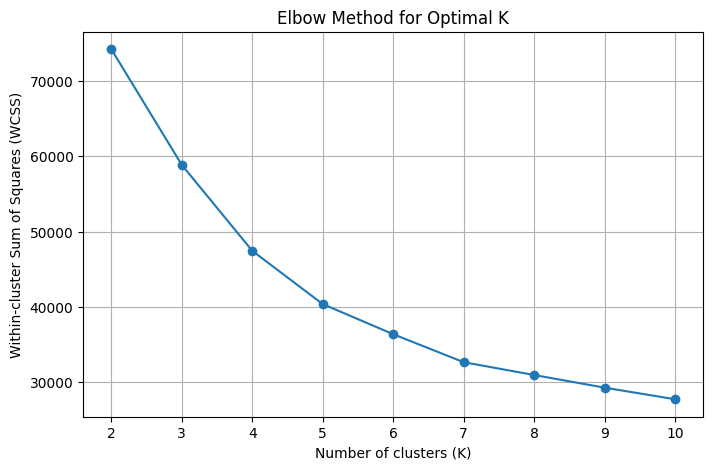

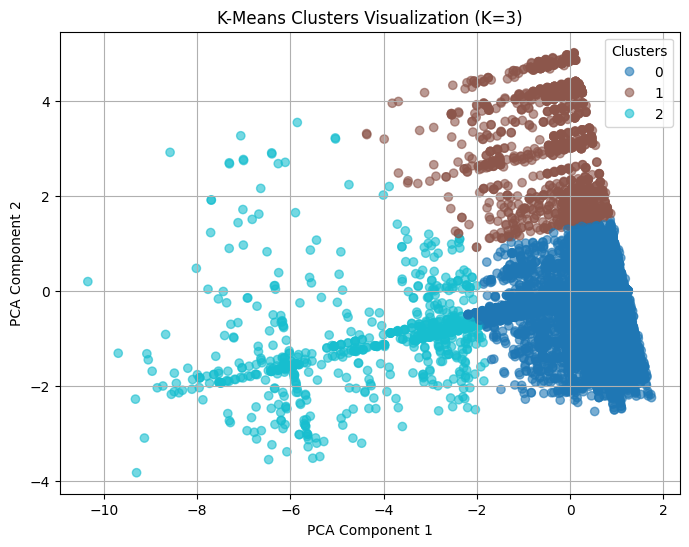

Cluster counts:
0    10104
1     1443
2      809
Name: count, dtype: int64


In [88]:
# -------------------------------
# Cell 9: K-Means Clustering and PCA Visualization
# -------------------------------

import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# -------------------------------
# Step 1: Elbow Method to find optimal K
# -------------------------------
wcss = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_kmeans)
    wcss.append(kmeans.inertia_)

# Plot elbow
plt.figure(figsize=(8,5))
plt.plot(K_range, wcss, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Within-cluster Sum of Squares (WCSS)')
plt.grid(True)
plt.show()

# -------------------------------
# Step 2: Fit K-Means with chosen K (e.g., K=4)
# -------------------------------
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_kmeans)

# Add cluster labels to dataframe
X_kmeans['Cluster'] = cluster_labels

# -------------------------------
# Step 3: PCA for 2D visualization
# -------------------------------
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_kmeans.drop('Cluster', axis=1))

plt.figure(figsize=(8,6))
scatter = plt.scatter(X_pca[:,0], X_pca[:,1], c=cluster_labels, cmap='tab10', alpha=0.6)
plt.title(f'K-Means Clusters Visualization (K={optimal_k})')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(*scatter.legend_elements(), title="Clusters")
plt.grid(True)
plt.show()

# -------------------------------
# Step 4: Optional: Cluster counts
# -------------------------------
cluster_counts = pd.Series(cluster_labels).value_counts().sort_index()
print("Cluster counts:")
print(cluster_counts)


In [89]:
# -------------------------------
# Cell 10: Cluster Profiling
# -------------------------------

# Group by cluster and calculate mean statistics
cluster_profile = X_kmeans.groupby('Cluster').agg({
    'num_branches': 'mean',
    'branch_age': 'mean',
    'population': 'mean',
    'total_hh': 'mean',
    'branch_density': 'mean'
}).round(2)

# Add cluster size
cluster_profile['Cluster_Size'] = X_kmeans['Cluster'].value_counts().sort_index()

# Display cluster profiling table
print("Cluster Profiling Summary:")
print(cluster_profile)

# Optional: save to CSV for documentation
cluster_profile.to_csv("cluster_profile_summary.csv", index=True)


Cluster Profiling Summary:
         num_branches  branch_age  population  total_hh  branch_density  \
Cluster                                                                   
0                0.01       -0.22       -0.29     -0.31           -0.06   
1               -0.17       -0.20        2.02      2.24            0.42   
2                0.16        3.08        0.01     -0.07           -0.02   

         Cluster_Size  
Cluster                
0               10104  
1                1443  
2                 809  


Silhouette Score for 6 clusters: 0.3660


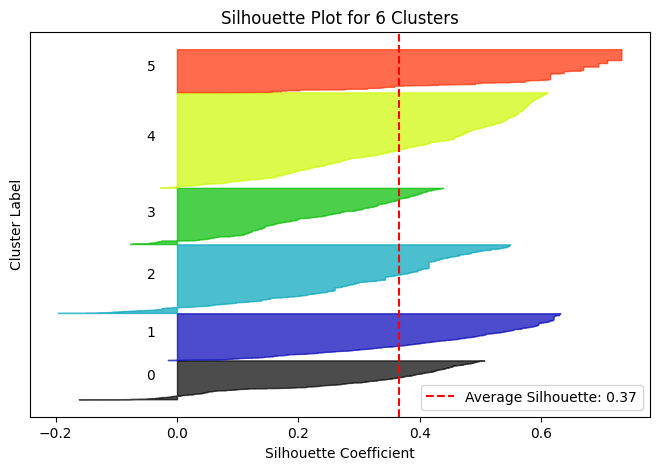

In [90]:
# -----------------------------
# Silhouette Analysis for 3 Clusters
# -----------------------------
from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib.pyplot as plt
import numpy as np

# Assuming X_scaled is your preprocessed and scaled data used for KMeans
k = 6
kmeans_3 = KMeans(n_clusters=k, random_state=42)
cluster_labels = kmeans_3.fit_predict(X_scaled)

# Silhouette score
sil_score = silhouette_score(X_scaled, cluster_labels)
print(f"Silhouette Score for {k} clusters: {sil_score:.4f}")

# Silhouette values for each sample
sil_values = silhouette_samples(X_scaled, cluster_labels)

# Plot silhouette plot
fig, ax = plt.subplots(figsize=(8, 5))
y_lower = 10
for i in range(k):
    ith_cluster_sil_values = sil_values[cluster_labels == i]
    ith_cluster_sil_values.sort()
    size_cluster_i = ith_cluster_sil_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = plt.cm.nipy_spectral(float(i) / k)
    ax.fill_betweenx(np.arange(y_lower, y_upper),
                     0, ith_cluster_sil_values,
                     facecolor=color, edgecolor=color, alpha=0.7)

    # Label cluster number
    ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    y_lower = y_upper + 10  # 10 for spacing

ax.set_title(f"Silhouette Plot for {k} Clusters")
ax.set_xlabel("Silhouette Coefficient")
ax.set_ylabel("Cluster Label")
ax.axvline(x=sil_score, color="red", linestyle="--", label=f"Average Silhouette: {sil_score:.2f}")
ax.set_yticks([])
ax.legend()
plt.show()


Random Forest Accuracy: 0.8912

Confusion Matrix:


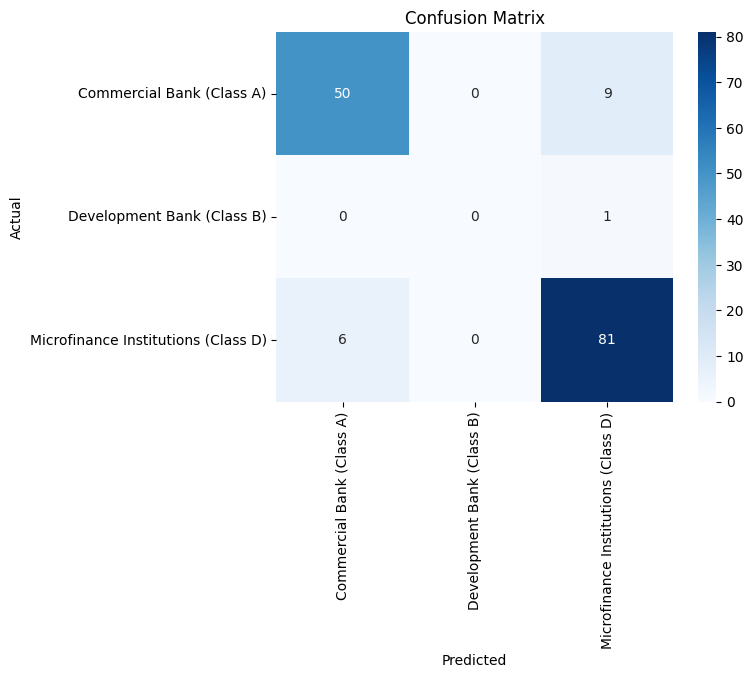


Classification Report:
                                     precision    recall  f1-score   support

          Commercial Bank (Class A)       0.89      0.85      0.87        59
         Development Bank (Class B)       0.00      0.00      0.00         1
Microfinance Institutions (Class D)       0.89      0.93      0.91        87

                           accuracy                           0.89       147
                          macro avg       0.59      0.59      0.59       147
                       weighted avg       0.89      0.89      0.89       147


Feature Importances:
          Feature  Importance
0    num_branches    0.322175
2      population    0.216382
1      branch_age    0.201675
3        total_hh    0.176043
4  branch_density    0.083725


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


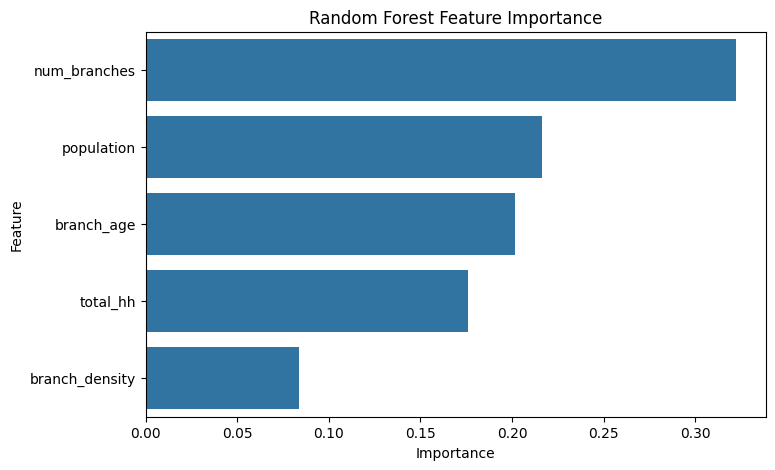

In [91]:
# -----------------------------
# Random Forest Classification
# -----------------------------
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Aggregate data to local-level (municipality)
# Assuming original BFI_ML dataframe has: 'municipality', 'type', 'branch_age', 'population', 'total_hh'
local_features = BFI_ML.groupby('municipality').agg({
    'num_branches': 'sum',
    'branch_age': 'mean',
    'population': 'sum',
    'total_hh': 'sum',
    'branch_density': 'mean',  # branches per 1000 population, for example
    'type': lambda x: x.mode()[0]  # dominant type in that municipality
}).reset_index()

# 2. Features and target
X = local_features[['num_branches', 'branch_age', 'population', 'total_hh', 'branch_density']]
y = local_features['type']

# 3. Encode target labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# 4. Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# 5. Feature scaling (optional for RF, but can help interpret feature importance)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 6. Random Forest Classifier
rf = RandomForestClassifier(
    n_estimators=200,     # number of trees
    max_depth=None,       # expand fully
    criterion='gini',
    random_state=42
)
rf.fit(X_train_scaled, y_train)

# 7. Predictions and evaluation
y_pred = rf.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print("Random Forest Accuracy:", round(accuracy, 4))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# 8. Feature Importance
importances = rf.feature_importances_
feature_names = X.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances}).sort_values(by='Importance', ascending=False)
print("\nFeature Importances:")
print(importance_df)

# Optional: plot feature importance
plt.figure(figsize=(8,5))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Random Forest Feature Importance')
plt.show()


In [92]:
from google.colab import files
import shutil

# Zip the folder
shutil.make_archive('figures_doc', 'zip', 'figures_doc')

# Download the zip file
files.download('figures_doc.zip')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>